In [ ]:
## Load packages for all chapter
import pandas as pd
import numpy as np
import nfl_data_py as nfl
import seaborn as sns
import matplotlib.pyplot as plt
import os


In [ ]:
from loader import get_pbp
pbp_py = get_pbp(range(2016, 2022 + 1))

In [ ]:
print(f"pbp_py.shape: {pbp_py.shape}")
## extract passing data
pbp_py_p = pbp_py.query("play_type == 'pass' & air_yards.notnull()").reset_index()
print(f"pbp_py_p.shape: {pbp_py_p.shape}")

pbp_py.shape: (336324, 392)
pbp_py_p.shape: (131607, 393)


In [11]:

## create filtering criteria
pbp_py_p["pass_length_air_yards"] = np.where(
    pbp_py_p["air_yards"] >= 20, "long", "short"
)

pbp_py_p["pass_length_air_yards"].describe()


count     131607
unique         2
top        short
freq      116087
Name: pass_length_air_yards, dtype: object

In [12]:

## replace missing values
pbp_py_p["passing_yards"] = np.where(
    pbp_py_p["passing_yards"].isnull(), 0, pbp_py_p["passing_yards"]
)

## describe passing data
pbp_py_p["passing_yards"].describe()


count    131607.000000
mean          7.192649
std           9.669308
min         -20.000000
25%           0.000000
50%           5.000000
75%          11.000000
max          98.000000
Name: passing_yards, dtype: float64

In [15]:

## summarize by pass length
pbp_py_p.query('pass_length_air_yards == "short"')["passing_yards"].describe()


count    116087.000000
mean          6.526777
std           7.699158
min         -20.000000
25%           0.000000
50%           5.000000
75%          10.000000
max          95.000000
Name: passing_yards, dtype: float64

In [16]:

## filter and only look at long passes
pbp_py_p.query('pass_length_air_yards == "long"')["passing_yards"].describe()


count    15520.000000
mean        12.173260
std         17.925947
min          0.000000
25%          0.000000
50%          0.000000
75%         26.000000
max         98.000000
Name: passing_yards, dtype: float64

In [17]:

## look at EPA for short passes
pbp_py_p.query('pass_length_air_yards == "short"')["epa"].describe()


count    116086.000000
mean          0.119740
std           1.426228
min         -13.031219
25%          -0.606098
50%          -0.002116
75%           0.959173
max           8.241420
Name: epa, dtype: float64

In [18]:

## look at EPA for long passes
pbp_py_p.query('pass_length_air_yards == "long"')["epa"].describe()


count    15520.000000
mean         0.382845
std          2.185511
min        -10.477922
25%         -0.827297
50%         -0.464970
75%          2.135163
max          8.789743
Name: epa, dtype: float64

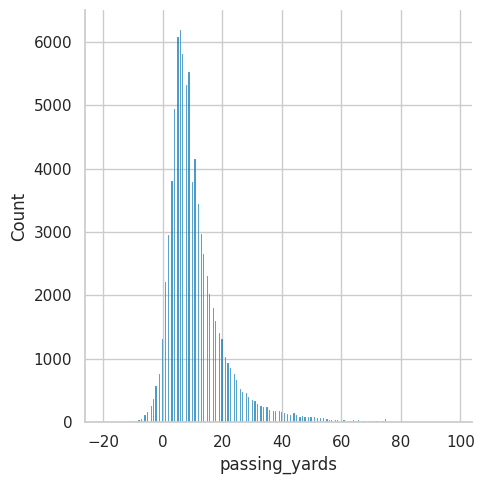

In [19]:

## histograms
sns.displot(data=pbp_py, x="passing_yards")
plt.show()


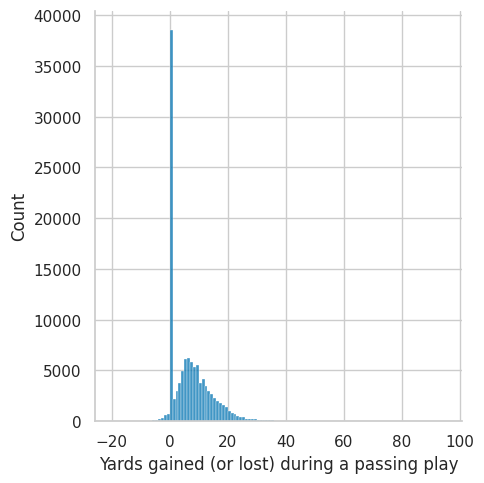

In [20]:

## set plot setting for rest of chapter
sns.set_theme(style="whitegrid", palette="colorblind")

## filter out for short passes
pbp_py_p_short = pbp_py_p.query('pass_length_air_yards == "short"')

## Clean up the plot
# Plot, change labels, and then show the output
pbp_py_hist_short = sns.displot(data=pbp_py_p_short, binwidth=1, x="passing_yards")
pbp_py_hist_short.set_axis_labels(
    "Yards gained (or lost) during a passing play", "Count"
)
plt.show()


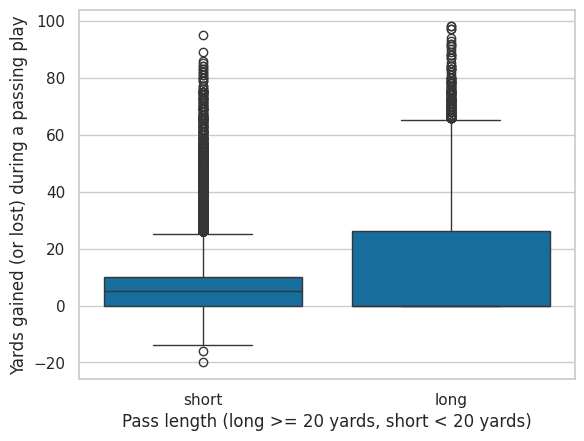

In [21]:

## pass boxplot Python
pass_boxplot = sns.boxplot(data=pbp_py_p, x="pass_length_air_yards", y="passing_yards")
pass_boxplot.set(
    xlabel="Pass length (long >= 20 yards, short < 20 yards)",
    ylabel="Yards gained (or lost) during a passing play",
)
plt.show()


In [ ]:

## player-level stability
## aggregate data
pbp_py_p_s = pbp_py_p.groupby(["passer_id", "passer", "season"]).agg(
    {"passing_yards": ["mean", "count"]}
)

## reformat columns
pbp_py_p_s.columns = list(map("_".join, pbp_py_p_s.columns.values))

## rename columns
pbp_py_p_s.rename(
    columns={"passing_yards_mean": "ypa", "passing_yards_count": "n"}, inplace=True
)

## look at results
## you will likely want to not include .head() to see all results
pbp_py_p_s.sort_values(by=["ypa"], ascending=False).head()

## select at players with more than 100 yards
pbp_py_p_s_100 = pbp_py_p_s.query("n >= 100").sort_values(by=["ypa"], ascending=False)

## Look at results
pbp_py_p_s_100.head()

## calculate at play-by-play passer data by season and pass length
pbp_py_p_s_pl = pbp_py_p.groupby(
    ["passer_id", "passer", "season", "pass_length_air_yards"]
).agg({"passing_yards": ["mean", "count"]})

## format and rename columns
pbp_py_p_s_pl.columns = list(map("_".join, pbp_py_p_s_pl.columns.values))
pbp_py_p_s_pl.rename(
    columns={"passing_yards_mean": "ypa", "passing_yards_count": "n"}, inplace=True
)

## reset pandas index
pbp_py_p_s_pl.reset_index(inplace=True)

## select only short passing data
q_value = (
    "(n >= 100 & "
    + 'pass_length_air_yards == "short") | '
    + "(n >= 30 & "
    + 'pass_length_air_yards == "long")'
)
pbp_py_p_s_pl = pbp_py_p_s_pl.query(q_value).reset_index()

## only save select columns
cols_save = ["passer_id", "passer", "season", "pass_length_air_yards", "ypa"]
air_yards_py = pbp_py_p_s_pl[cols_save].copy()

## create lag data
air_yards_lag_py = air_yards_py.copy()
air_yards_lag_py["season"] += 1
air_yards_lag_py.rename(columns={"ypa": "ypa_last"}, inplace=True)

## merge lag data back in
pbp_py_p_s_pl = air_yards_py.merge(
    air_yards_lag_py,
    how="inner",
    on=["passer_id", "passer", "season", "pass_length_air_yards"],
)

## Look at merged data for two passers
print(
    pbp_py_p_s_pl[["pass_length_air_yards", "passer", "season", "ypa", "ypa_last"]]
    .query('passer == "T.Brady" | passer == "A.Rodgers"')
    .sort_values(["passer", "pass_length_air_yards", "season"])
    .to_string()
)

## Look at the info the dataframe
pbp_py_p_s_pl.info()

## see number of quarterbacks
len(pbp_py_p_s_pl.passer_id.unique())

## plot scatterplot with Python
sns.lmplot(data=pbp_py_p_s_pl, x="ypa", y="ypa_last", col="pass_length_air_yards")
plt.show()

## Look at correlation in Python
pbp_py_p_s_pl.query("ypa.notnull() & ypa_last.notnull()").groupby(
    "pass_length_air_yards"
)[["ypa", "ypa_last"]].corr()

## 2017 YPA leaderboard
pbp_py_p_s_pl.query('pass_length_air_yards == "long" & season == 2017')[
    ["passer_id", "passer", "ypa"]
].sort_values(["ypa"], ascending=False).head(10)

## 2018 YPA leaderboard
pbp_py_p_s_pl.query('pass_length_air_yards == "long" & season == 2018')[
    ["passer_id", "passer", "ypa"]
].sort_values(["ypa"], ascending=False).head(10)
